In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cmath import exp
from math import sin,  cos

# Define a class to handle the TFIM 

In [2]:
class TransIsingH:
    def __init__(self,l,j,hx,hz):
        self.l   = int(l)
        self.dim = 1 << self.l
        assert len(j) >= l
        self.j   = np.array(j,dtype=float)
        assert len(hx) >= l
        self.hx  = np.array(hx,dtype=float)
        assert len(hz) >= l
        self.hz  = np.array(hz,dtype=float)
    def mult(self,x):
        """ Action of H on a state """
        y=np.zeros_like(x)
        self.dim = 1 << self.l
        assert len(x) >= self.dim
        # Diagonal part (J and hz)
        for s in range(self.dim):
            jtotal = 0.
            for r in range(self.l-1):
                jtotal += -self.j[r] if ((s >> r)^(s >> (r+1)))&1 else self.j[r]
            for r in range(self.l):
                jtotal += bool(s&(1 << r)) * self.hz[r]
            y[s] = jtotal * x[s]
        # Off-diagonal part (hx)
        for s  in range(self.dim):
            for r in range(self.l):
                sflip = s ^ (1 << r)
                y[sflip] += self.hx[r] * x[s]
        return y
    def Hsparse(self, dtype = float): # for testing purposes
        """ Construct a sparse Hamiltonian """
        H = sp.lil_matrix((self.dim,self.dim),dtype = dtype)
        self.dim = 1 << self.l
        # Diagonal part (J and hz)
        for s in range(self.dim):
            jtotal = 0.
            for r in range(self.l-1):
                jtotal += -self.j[r] if ((s >> r)^(s >> (r+1)))&1 else self.j[r]
            for r in range(self.l):
                jtotal += bool(s&(1 << r)) * self.hz[r]
            H[s,s] = jtotal 
        # Off-diagonal part (hx)
        for s  in range(self.dim):
            for r in range(self.l):
                sflip = s ^ (1 << r)
                H[sflip,s] += self.hx[r]
        return H
    def evolve(self, x, dt, n):
        """ Evolve the state v in time by n * dt """
        # Since transverse field and diagonal part don't commute they are applied
        # in a split-operator scheme
        x = self._tstep_diag(x, dt/2.)
        for i in range(int(n-1)):
            x = self._tstep_transv(x, dt)
            x = self._tstep_diag(x, dt)
        x = self._tstep_transv(x, dt)
        x = self._tstep_diag(x, dt/2.)
        return x
    def _tstep_diag(self, x, dt):
        y =  np.zeros_like(x)
        # Apply diagonal part
        for s in range(self.dim):
            jtotal = 0.
            for r in range(self.l-1):
                jtotal += -self.j[r] if ((s >> r)^(s >> (r+1)))&1 else self.j[r]
            for r in range(self.l):
                jtotal += bool(s&(1 << r)) * self.hz[r]
            y[s] = exp(-1.j*jtotal*dt)*x[s]
        return y
    def _tstep_transv(self, x, dt):
        # Apply transverse part
        y =  np.zeros_like(x)
        for r in range(self.l):
            # diagonal
            for s in range(self.dim):
                y[s] = cos(dt*self.hx[r]) * x[s]
            # off-diagonal
            for s in range(self.dim):
                y[s^(1<<r)] += -1.j*sin(dt*self.hx[r]) * x[s]
            # swap vectors
            tmp = x
            x   = y
            y   = tmp
        return x

# Solve the exercise

## Only transverse field

In [3]:
l   =  9
dim =  1 << l
j   =  0.00*np.ones((l))
hx  =  0.40*np.ones((l))
hz  =  0.00*np.ones((l))

In [4]:
H = TransIsingH(l,j,hx,hz)

In [5]:
# Starting configuration
ind = int('000000000',base=2)
v   = np.zeros((dim),dtype=complex)
v[ind] = 1.

In [6]:
# Do time evolution
tstart = 0.
tend   = 20.
tmeas  = 0.5
dt     = 0.1
nmeas  = int((tend-tstart)/tmeas)
nstep  = int((tend-tstart)/nmeas/dt)


In [7]:
# measure magnetization
m=np.zeros((nmeas,l));
for r in range(l):
    for s in range(dim):
        m[0,r] += abs(v[s])**2 * 2. * ( bool(s&(1 << r)) -0.5)

In [8]:
for t in range(1,nmeas):
    print(t*tmeas)
    v=H.evolve(v,dt,nstep)
    # measure magnetization
    for r in range(l):
        for s in range(dim):
            m[t,r] += abs(v[s])**2 * 2. * ( bool(s&(1 << r)) -0.5)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5


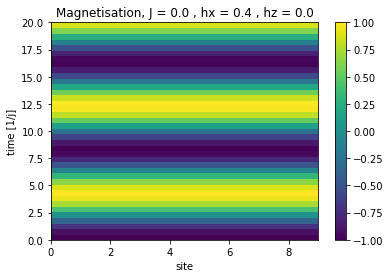

In [9]:
# plot magnetization
plt.pcolor(np.array(range(l+1)),np.linspace(tstart,tend,nmeas),m,
           vmin=-1.0, vmax=1.0)
plt.xlabel('site')
plt.ylabel('time [1/j]')
plt.axis([0,l,tstart,tend])
plt.title("Magnetisation, J = "+str(j[0])+" , hx = "+str(hx[0])+" , hz = "+str(hz[0]))
plt.colorbar()
plt.show()


## Turn on the spin-spin Ising interaction

In [11]:
l   =  9
dim =  1 << l
j   =  1.00*np.ones((l))
hx  =  0.40*np.ones((l))
hz  =  0.00*np.ones((l))

In [12]:
H = TransIsingH(l,j,hx,hz)

In [13]:
# Starting configuration
ind = int('000010000',base=2)
v   = np.zeros((dim),dtype=complex)
v[ind] = 1.

In [14]:
# Do time evolution
tstart = 0.
tend   = 20.
tmeas  = 0.5
dt     = 0.1
nmeas  = int((tend-tstart)/tmeas)
nstep  = int((tend-tstart)/nmeas/dt)


In [15]:
# measure magnetization
m=np.zeros((nmeas,l));
for r in range(l):
    for s in range(dim):
        m[0,r] += abs(v[s])**2 * 2. * ( bool(s&(1 << r)) -0.5)

In [16]:
for t in range(1,nmeas):
    print(t*tmeas)
    v=H.evolve(v,dt,nstep)
    # measure magnetization
    for r in range(l):
        for s in range(dim):
            m[t,r] += abs(v[s])**2 * 2. * ( bool(s&(1 << r)) -0.5)

0.5
1.0
1.5
2.0
2.5
3.0
3.5
4.0
4.5
5.0
5.5
6.0
6.5
7.0
7.5
8.0
8.5
9.0
9.5
10.0
10.5
11.0
11.5
12.0
12.5
13.0
13.5
14.0
14.5
15.0
15.5
16.0
16.5
17.0
17.5
18.0
18.5
19.0
19.5


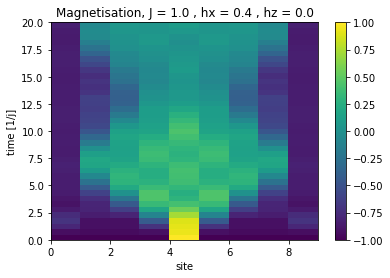

In [17]:
# plot magnetization
plt.pcolor(np.array(range(l+1)),np.linspace(tstart,tend,nmeas),m,
           vmin=-1.0, vmax=1.0)
plt.xlabel('site')
plt.ylabel('time [1/j]')
plt.axis([0,l,tstart,tend])
plt.title("Magnetisation, J = "+str(j[0])+" , hx = "+str(hx[0])+" , hz = "+str(hz[0]))
plt.colorbar()
plt.show()